EpistemicPropagationBlackBboxWorkshop

# Import the needed libraries

In [1]:
import subprocess  # needed for running the function
import os  # needed for running the function
from PyUncertainNumber.characterisation.uncertainNumber import UncertainNumber as UN
from PyUncertainNumber.characterisation.utils import UNEncoder, cd_root_dir
from PyUncertainNumber import UncertainNumber as UN
import numpy as np

from PyUncertainNumber.propagation.uncertaintyPropagation import Propagation

# XFOIL

XFOIL is an interactive program for analyzing isolated subsonic airfoils, available under the GNU General Purpose License. For more details, see https://web.mit.edu/drela/Public/web/xfoil .

A special version, v6.99uq, has been compiled with enhanced features like increased output precision, a higher maximum panel count (2048), and adjustable boundary layer convergence criteria. Executables for Windows, MacOS, and Linux, provided by Marshall Galbraith of MIT, are available in a compressed tar file found in the link below

https://acdl.mit.edu/galbramc/UQ_Challenge/xfoil_execs.tgz




# Problem setup

Use XFOIL to compute the **lift**, c_l, and **moment** c_m, **coefficients** for:

- NACA 2412 airfoil
- simple flap starting at 70% chord and hinged at the midpoint
- incompressible, viscous flow
- 100 panels are to be used in all analyses except in estimating the discretisation error

Assess whether, at nominally zero degree angle of attack and flap deflection:
-  0.155 ≤ c_l ≤  0.265 
- -0.050 ≤ c_m ≤ -0.044

##TODO what can we say about their dependence/correlation? 
##TODO the software shoudl give you the input combinations, without a function.
##TODO endpoint cauchy, bernstein ??
##TODO only with aleatory , just monte carlo, what about dependence/correlation? 
##TODO Mitcell truss, how it would work given there is not intrusive access to the code or possibility to run it through python. 

# Problem parameterisation
Table 1. Summary of uncertain parameters 
![alt text](<Screenshot 2024-11-05 155042.png>)

# Create the function

A function is created which calculates the lift coefficient (c_l) and moment coefficient (c_m) for a given set of input parameters using XFOIL
- The function's input is only the uncertain numbers.
- The deterministic inpyt are defined within the function. 
- As sampling techniques are used it is likley that for a certain input combination the airfoil will fail to reach a solution. we use the try function to accomodate for this. 

In [2]:
def coef_xfoil(x):
    """
    Calculates the lift coefficient (c_l) and moment coefficient (c_m) for a given 
    set of input parameters using XFOIL.

    Args:
        x np.array: An np.array of input parameters containing:
            x[0]: Flap deflection angle (float)
            x[1]: Reynolds number (float)
            x[2]: Upper surface trip location (float)
            x[3]: Lower surface trip location (float)
            x[4]: Angle of attack (alpha) (float)

    Returns:
        np.array: A numpy array containing the lift coefficient (c_l) and moment coefficient (c_m).
    """
    try:
        # Certain Input parameters
        airfoil_name = 2412
        pacc = 1
        flap_hinge_x = 0.70  
        flap_hinge_y = 999
        flap_hinge_r = 0.50
        no_panel_nodes = 256
        Mach = 0.00 
       
        # Create the XFOIL input file
        input_file = open("C:\\Users\\Ioanna\\Documents\\GitHub\\daws2\\xfoil_workshop\\input_file_cha.in", 'w')
        input_file.write("NACA {0}\n".format(airfoil_name))
        input_file.write("gdes\n")
        input_file.write("flap\n")
        input_file.write(str(flap_hinge_x))
        input_file.write("\n")
        input_file.write(str(flap_hinge_y))
        input_file.write("\n")
        input_file.write(str(flap_hinge_r))
        input_file.write("\n")
        input_file.write(str(format(x[0], '.4f')))  # flap deflection
        input_file.write("\n")
        input_file.write("exec\n\n")
        input_file.write("ppar\n")
        input_file.write("n {0}\n".format(no_panel_nodes))
        input_file.write("p {0}\n".format(1.0))
        input_file.write("\n\n")
        input_file.write("oper\n")
        input_file.write("mach {0}\n".format(Mach))
        #input_file.write("iter {0}\n".format(100))
        input_file.write("visc\n")
        input_file.write(str(format(x[1], '.0f')))  # Reynolds number
        input_file.write("\n")
        input_file.write("vpar\n")
        input_file.write("xtr\n")
        input_file.write(str(format(x[2], '.4f')) ) # Upper Surface Trip Location
        input_file.write("\n")
        input_file.write(str(format(x[3], '.4f'))) # Lower Surface Trip Location
        input_file.write("\n\n")
        input_file.write("pacc {0}\n".format(pacc))
        input_file.write("C:\\Users\\Ioanna\\Documents\\GitHub\\daws2\\xfoil_workshop\\output_up.txt\n\n")
        input_file.write("alfa\n")
        input_file.write(str(format(x[4], '.4f')))  # alpha
        input_file.write("\n\n")
        input_file.write("quit\n")
        input_file.close()
        
        # Run XFOIL
        subprocess.call("C:\\Users\\Ioanna\\Documents\\GitHub\\daws2\\xfoil_workshop\\xfoil.exe < C:\\Users\\Ioanna\\Documents\\GitHub\\daws2\\xfoil_workshop\\input_file_cha.in", shell=True)
        
        # Extract results from the output file
        old_file_name = "C:\\Users\\Ioanna\\Documents\\GitHub\\daws2\\xfoil_workshop\\output_up"  # Or the current file name with any extension
        new_file_name = "C:\\Users\\Ioanna\\Documents\\GitHub\\daws2\\xfoil_workshop\\output_up.txt"
        os.rename(old_file_name, new_file_name)

        results = np.loadtxt(("C:\\Users\\Ioanna\\Documents\\GitHub\\daws2\\xfoil_workshop\\output_up.txt"), 
                     skiprows=12, encoding='latin1')
        
        c_l = results[1]  # Extract lift coefficient
        c_m = results[4]  # Extract moment coefficient

    except FileNotFoundError:
        print("Error: XFOIL executable not found. Please check the path.")
        return np.array([0.0, 0.0])
    except IndexError:
        print("Error: XFOIL output file is empty or has unexpected format.")
        return np.array([0.0, 0.0])
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return np.array([0.0, 0.0])
    finally:        
        # Remove the output file (if it exists)
        try:
            os.unlink("C:\\Users\\Ioanna\\Documents\\GitHub\\daws2\\xfoil_workshop\\output_up.txt")
        except FileNotFoundError:
            pass

    # Return the results as a numpy array
    return np.array([c_l, c_m]) 


#### Test the installation

To ensure that the installation is correct, try to match the results with the following expected output values. Variations in the final 3-4 significant figures are expected. 

In [3]:
# test the function
flap_deflection = 0.5
Re = 500000
xtr_top = 0.3
xtr_bottom = 0.7
alpha = 0
# for no_panel_nodes = 256

# Create a 2D np.array with all input parameters in the **correct** order.
ranges = np.array([flap_deflection, Re,  xtr_top, xtr_bottom, alpha])

# Run the function
coef_xfoil(ranges)

# Comment out the following lines from the coef_xfoil function so the output file is not deleted after each run.
#finally:
        # Remove the output file (if it exists)
      #  try:
           # os.unlink("C:\\Users\\Ioanna\\Documents\\GitHub\\daws2\\xfoil_workshop\\output_up.txt")
     #   except FileNotFoundError:
      #      pass

# Open the output.txt file and check that the following coeffcients 

#CL      = 0.245832312525558E+00
#CD      = 0.897255056288259E-02
#CDp     = 0.639220543894256E-03    
#CM      =-0.525018720205690E-01
#Top_Xtr = 0.300000000000043E+00 
#Bot_Xtr = 0.700000000000001E+00 
#Top_Itr = 0.286192798167708E+02 
#Bot_Itr = 0.881204554341905E+02

array([ 0.24657635, -0.05268048])

In what follows variou assumptions are performed to highlight for no_panel_nodes = 100

***
<a id="propagate_epistemic_uncertainty"></a>
# Epistemic uncertainty

# Propagate aleatory uncertainty 

Step 2. Create 5 uncertain numbers assuming they follow a normal distribution with the parameters provided in Table 1.

***
<a id="Aleatory_propagation"></a>
# 3. Aleatory uncertainty

In [4]:

flap_deflection = UN(name='flap deflection',  symbol='flap_d', units='degrees', 
            essence="distribution", distribution_parameters=["gaussian", [0, 0.08]])
Re  = UN(name='Reynolds number', symbol='Re', 
            essence="distribution", distribution_parameters=["gaussian", [500000, 2500]])
xtr_top = UN(name='Upper Surface Trip Location', symbol='xtr_top', 
            essence="distribution", distribution_parameters=["gaussian", [0.3, 0.015]])
xtr_bottom = UN(name='Lower Surface Trip Location', symbol='xtr_bot',   
            essence="distribution", distribution_parameters=["gaussian", [0.7, 0.021]])
alpha = UN(name='angle of attaack', symbol='a', units='degrees', 
           essence="distribution", distribution_parameters=["gaussian", [0, 0.1]])

#input
vars_alea = [flap_deflection, Re, xtr_top, xtr_bottom, alpha]

In [5]:
print(Re)

UncertainNumber(name='Reynolds number', symbol='Re', _Q=<Quantity(500000.0, 'dimensionless')>, essence='distribution', distribution_parameters=['gaussian', [500000, 2500]], _construct=dist ~ gaussian[500000, 2500], naked_value=np.float64(500000.0), p_flag=True)


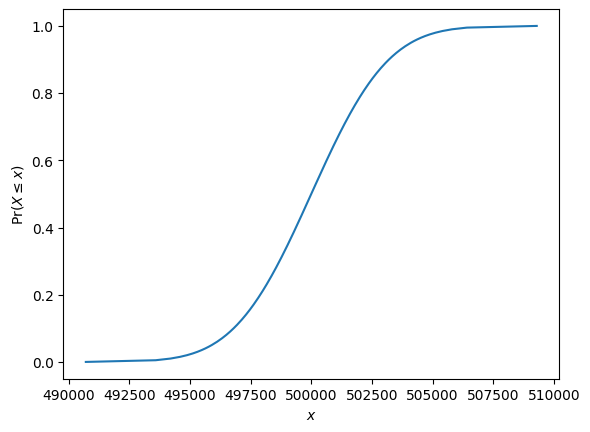

In [6]:
Re.display()

In [7]:
# Propagate the aleatory uncertainty with monte_carlo
y_alea_mc = Propagation(vars_alea, coef_xfoil, 
                #n_sam =500, 
                method = 'monte_carlo')

Total number of input combinations for the monte_carlo method: 500


Evaluating samples: 100%|██████████| 500/500 [01:19<00:00,  6.32it/s]


In [8]:
y_alea_mc.summary()

------------------------------
Output 1:
------------------------------
Uncertain Number: dist ~ sample-approximated distribution object
------------------------------
Output 2:
------------------------------
Uncertain Number: dist ~ sample-approximated distribution object
------------------------------
Input combinations and corresponding output(s):
x: [[ 3.90889663e-04  4.97989196e+05  3.12467636e-01  7.13653094e-01
  -8.92723200e-02]
 [ 1.10740191e-02  5.02731919e+05  3.28823988e-01  6.85888239e-01
   8.55948976e-02]
 [-4.18632933e-02  4.95752813e+05  2.83383657e-01  6.80956686e-01
   7.36166796e-02]
 ...
 [-1.22019536e-03  4.98290686e+05  3.01866219e-01  6.85282596e-01
  -6.57698116e-02]
 [ 8.38702750e-02  5.03226458e+05  2.91292803e-01  6.96899907e-01
   5.04139457e-02]
 [-8.33972942e-02  5.00564709e+05  2.99516416e-01  6.84237110e-01
  -8.64224941e-03]]
------------------------------
f: [[ 0.19974258 -0.04716085]
 [ 0.22286067 -0.04775901]
 [ 0.21543807 -0.04691371]
 [ 0.20005746

In [9]:
# Propagate the aleatory uncertainty with latin_hypercube
y_alea_lhs = Propagation(vars_alea, coef_xfoil, 
                #n_sam =500, 
                method = 'latin_hypercube')

Total number of input combinations for the latin_hypercube method: 500


Evaluating samples: 100%|██████████| 500/500 [01:17<00:00,  6.48it/s]


# Epistemic uncertainty 

In [10]:
# Uncertainty characterisation
flap_deflection = UN(name='flap deflection', symbol='flap_d',  units='degrees', essence='interval', bounds= [-0.24, 0.24])
Re = UN(name='Reynolds Number', symbol='Re',  essence='interval', bounds= [492500, 507500])
xtr_top = UN(name='Upper Surface Trip Location', symbol='xtr_top',  essence='interval', bounds=[0.255, 0.345])
xtr_bottom = UN(name='Lower Surface Trip Location', symbol='xtr_bot',  essence='interval', bounds= [0.637, 0.763])
alpha = UN(name='angle of attaack', symbol='a', units='degrees', essence='interval', bounds= [-0.3, 0.3])

#input
vars_epi = [flap_deflection, Re, xtr_top, xtr_bottom, alpha]

In [11]:
# Plot the uncertain numbers

# flap_deflection.display()
# Re.display()
# xtr_top.display()
# xtr_bottom.display()
# alpha.display()

### Endpoint propagation

The endpoint propagation method (Dong and Shah, 1987) is a straightforward way to project intervals through the code, by projecting all input combinations produced by the Cartesian product of the interval bounds. This results in a total of n = 2**d. 

For the working example, there are d = 5 intervals which results in n = 2**5 = 32 input combinations.

#### Assumptions




In [12]:
# How many input combinations are expected from the endpoint propagation?
d = 5 # is the number of uncertain input expressed as intervals.
n = 2**d # The total number of combinations 
print("Total number of input combinations for the endpoint method:", n) 

Total number of input combinations for the endpoint method: 32


In [13]:
y_end = Propagation(vars_epi, coef_xfoil, method = 'endpoints')

Total number of input combinations for the endpoint method: 32


Evaluating samples: 100%|██████████| 32/32 [00:05<00:00,  6.16it/s]


In [14]:
# check the results.
y_end.summary()

------------------------------
Output 1:
------------------------------
Uncertain Number: UncertainNumber(_Q=<Quantity(0.209725545, 'dimensionless')>, essence='interval', bounds=array([0.1523357 , 0.26711539]), _construct=Interval [0.152336, 0.267115], naked_value=np.float64(0.2097255452185155), p_flag=True)
------------------------------
Bounds: [0.1523357  0.26711539]
------------------------------
Minimum:
f: 0.152335700570157
x: [[-2.400e-01  4.925e+05  2.550e-01  7.630e-01 -3.000e-01]]
------------------------------
Maximum:
f: 0.267115389866874
x: [[2.400e-01 5.075e+05 3.450e-01 6.370e-01 3.000e-01]]
------------------------------
Output 2:
------------------------------
Uncertain Number: UncertainNumber(_Q=<Quantity(-0.0471273098, 'dimensionless')>, essence='interval', bounds=array([-0.05083742, -0.0434172 ]), _construct=Interval [-0.0508374, -0.0434172], naked_value=np.float64(-0.047127309819833), p_flag=True)
------------------------------
Bounds: [-0.05083742 -0.0434172 ]
---

### Subinterval reconstitution propagation

The input intervals are partitioned into smaller intervals, which are then propagated through the model using endpoint propagation and the output interval can be reassembled (Ferson and Hajagos, 2004).

In [15]:
# How many input combinations are expected from the subinterval reconstitution propagation?
d = 5 # is the number of uncertain input expressed as intervals.
m = 4 # is the number of partitions. 
n = (m+1)**d # The total number of combinations 
print("Total number of input combinations for the subinterval reconstitution method:", n) 

Total number of input combinations for the subinterval reconstitution method: 3125


In [16]:
y_sub = Propagation(vars_epi, coef_xfoil, 
                    # n_sub = 3, 
                    method = 'subinterval')

Total number of input combinations for the subinterval method: 1024


Evaluating samples: 100%|██████████| 1024/1024 [02:46<00:00,  6.14it/s]


In [17]:
# check the results.
y_sub.raw_data['max']

array([{'x': array([[0.24, 507500.0, 0.345, 0.637, 0.3]], dtype=object), 'f': np.float64(0.267115389866874)},
       {'x': array([[-0.24, 492500.0, 0.255, 0.763, -0.3]], dtype=object), 'f': np.float64(-0.0434172008738895)}],
      dtype=object)

### Sampling methods

In [18]:
y_mc = Propagation(vars_epi, coef_xfoil, 
                    # n_sam = 500, 
                    method = "monte_carlo")

Total number of input combinations for the monte_carlo method: 500


Evaluating samples: 100%|██████████| 500/500 [01:17<00:00,  6.45it/s]


In [19]:
# check the results.
y_mc.summary()

------------------------------
Output 1:
------------------------------
Uncertain Number: UncertainNumber(_Q=<Quantity(0.209159428, 'dimensionless')>, essence='interval', bounds=array([0.16142936, 0.25688949]), _construct=Interval [0.161429, 0.256889], naked_value=np.float64(0.20915942824720452), p_flag=True)
------------------------------
Bounds: [0.16142936 0.25688949]
------------------------------
Minimum:
f: 0.161429363784399
x: [[-2.35598714e-01  5.02094944e+05  2.98827681e-01  6.78611722e-01
  -2.81212625e-01]]
------------------------------
Maximum:
f: 0.25688949271001
x: [[1.86403777e-01 4.96824513e+05 3.44302809e-01 7.28287275e-01
  2.81589936e-01]]
------------------------------
Output 2:
------------------------------
Uncertain Number: UncertainNumber(_Q=<Quantity(-0.0472403835, 'dimensionless')>, essence='interval', bounds=array([-0.05053417, -0.0439466 ]), _construct=Interval [-0.0505342, -0.0439466], naked_value=np.float64(-0.04724038354575555), p_flag=True)
------------

In [20]:
y_mc_end = Propagation(vars_epi, coef_xfoil, 
                    # n_sam = 500, 
                    method = 'monte_carlo_endpoints')

Total number of input combinations for the monte_carlo method: 500


Evaluating samples: 100%|██████████| 532/532 [01:21<00:00,  6.49it/s]


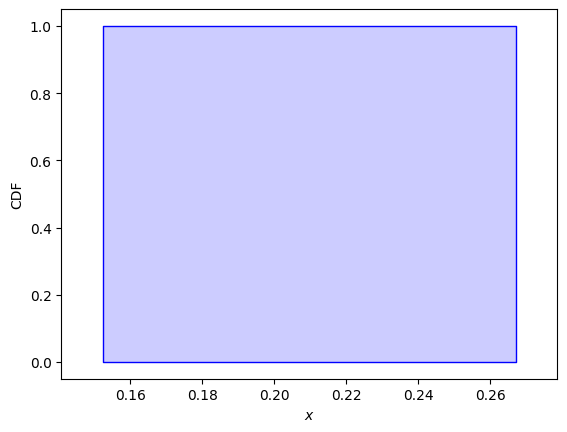

In [21]:
y_mc_end.un[0].display()

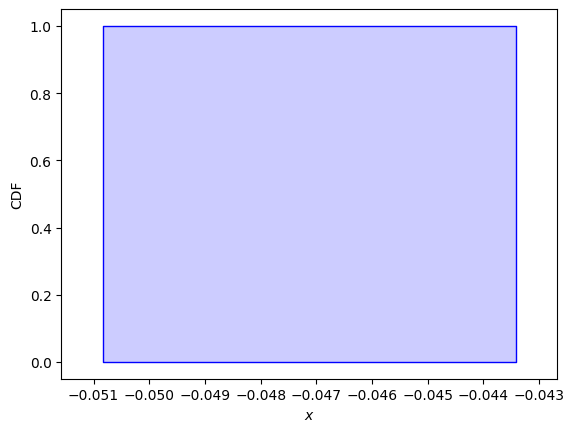

In [22]:
y_mc_end.un[1].display()

In [44]:
y_lhs = Propagation(vars_epi, coef_xfoil, 
                    # n_sam = 500, 
                    method = "latin_hypercube")

Total number of input combinations for the latin_hypercube method: 500


Evaluating samples: 100%|██████████| 500/500 [01:45<00:00,  4.76it/s]


In [23]:
y_cauchy = Propagation(vars_epi, coef_xfoil, 
                    # n_sam = 500, 
                    method = 'cauchy')

Total number of input combinations for the endpoints Cauchy deviates method: 500


Calculating Cauchy deviates:   3%|▎         | 14/500 [00:02<01:23,  5.83it/s]C:\Users\Ioanna\AppData\Local\Temp\ipykernel_37036\3633351781.py:73: UserWarning: loadtxt: input contained no data: "C:\Users\Ioanna\Documents\GitHub\daws2\xfoil_workshop\output_up.txt"
  results = np.loadtxt(("C:\\Users\\Ioanna\\Documents\\GitHub\\daws2\\xfoil_workshop\\output_up.txt"),
Calculating Cauchy deviates:   3%|▎         | 16/500 [00:04<04:21,  1.85it/s]

Error: XFOIL output file is empty or has unexpected format.


Calculating Cauchy deviates:   6%|▋         | 32/500 [00:06<01:15,  6.18it/s]

Error: XFOIL output file is empty or has unexpected format.


Calculating Cauchy deviates:   8%|▊         | 42/500 [00:08<01:19,  5.78it/s]

Error: XFOIL output file is empty or has unexpected format.


Calculating Cauchy deviates:  17%|█▋        | 84/500 [00:15<01:05,  6.38it/s]

Error: XFOIL output file is empty or has unexpected format.


Calculating Cauchy deviates:  21%|██▏       | 107/500 [00:19<01:10,  5.59it/s]

Error: XFOIL output file is empty or has unexpected format.


Calculating Cauchy deviates:  24%|██▎       | 118/500 [00:21<01:07,  5.65it/s]

Error: XFOIL output file is empty or has unexpected format.


Calculating Cauchy deviates:  30%|██▉       | 148/500 [00:26<01:01,  5.75it/s]

Error: XFOIL output file is empty or has unexpected format.


Calculating Cauchy deviates:  38%|███▊      | 191/500 [00:33<00:51,  6.05it/s]

Error: XFOIL output file is empty or has unexpected format.


Calculating Cauchy deviates:  43%|████▎     | 214/500 [00:37<00:47,  6.00it/s]

Error: XFOIL output file is empty or has unexpected format.


Calculating Cauchy deviates:  44%|████▍     | 221/500 [00:38<00:46,  6.03it/s]

Error: XFOIL output file is empty or has unexpected format.


Calculating Cauchy deviates:  50%|█████     | 251/500 [00:43<00:41,  6.06it/s]

Error: XFOIL output file is empty or has unexpected format.


Calculating Cauchy deviates:  69%|██████▉   | 347/500 [00:59<00:30,  4.97it/s]

Error: XFOIL output file is empty or has unexpected format.


Calculating Cauchy deviates:  71%|███████   | 354/500 [01:02<01:19,  1.83it/s]

Error: XFOIL output file is empty or has unexpected format.


Calculating Cauchy deviates:  74%|███████▍  | 372/500 [01:05<00:19,  6.66it/s]

Error: XFOIL output file is empty or has unexpected format.


Calculating Cauchy deviates:  78%|███████▊  | 390/500 [01:08<00:24,  4.48it/s]

Error: XFOIL output file is empty or has unexpected format.


Calculating Cauchy deviates:  81%|████████  | 403/500 [01:11<00:16,  5.81it/s]

Error: XFOIL output file is empty or has unexpected format.


Calculating Cauchy deviates:  81%|████████  | 405/500 [01:11<00:15,  6.27it/s]

Error: XFOIL output file is empty or has unexpected format.


Calculating Cauchy deviates:  82%|████████▏ | 412/500 [01:12<00:16,  5.36it/s]

Error: XFOIL output file is empty or has unexpected format.


Calculating Cauchy deviates: 100%|██████████| 500/500 [01:27<00:00,  5.73it/s]


Input x for min max y are NOT available for the Cauchy method!


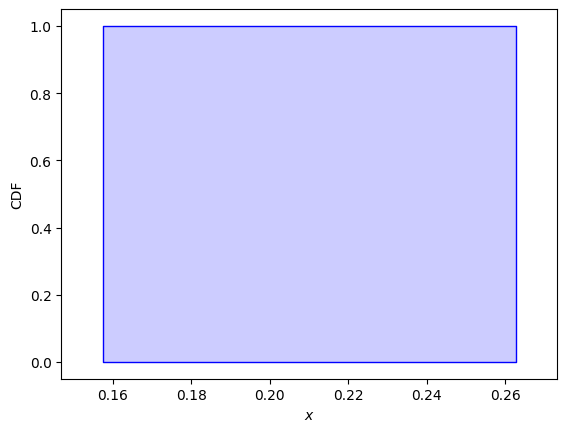

In [24]:
y_cauchy.un[0].display()

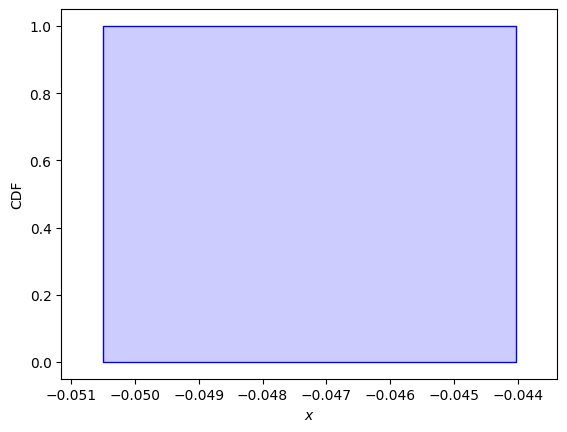

In [25]:
y_cauchy.un[1].display()

In [26]:
y_cauchy.un[1].bounds


array([-0.0505043, -0.0440319])

### Optimisation methods

Plotting the intervals

In [49]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_interval(vars, colors=None, xlabel= None, labels: list= None, vlines:list=None):
    """
    Plots an interval on a Matplotlib plot.

    args:
        interval (np.ndarray or list): The interval to plot.
        color (str, optional): The color of the interval line. If None, it cycles through default colors. Defaults to None.
        label (str, optional): The label for the interval in the legend. Defaults to None.
        vline (float, optional): x-coordinate for the vertical line. If None, no vertical line is plotted. Defaults to None.
    """
    intervals = np.zeros((len(vars), 2))
    for i, un in enumerate(vars):
        intervals[i, :] = un.bounds  # Get an np.array of bounds for all vars

    # Automatic color cycling if colors is not provided
    if colors is None:
        cmap = cm.get_cmap('tab10')  # Use 'tab10' colormap
        colors = [cmap(i % 10) for i in range(len(vars))]  # Generate a list of colors


    if labels is None:
        labels = np.zeros((len(vars)))
        for i, un in enumerate(vars):
            labels[i, :] = un.symbol  # Get an np.array of bounds for all vars
 
    for i, interval in enumerate(intervals):
        if isinstance(interval, np.ndarray) and interval.size == 2:
            lower_bound, upper_bound = interval[0], interval[1]
        elif isinstance(interval, list) and len(interval) == 2:
            lower_bound, upper_bound = interval[0], interval[1]
        else:
            raise ValueError(f"Invalid interval format for interval {i + 1}. Please provide a NumPy array or a list with two elements [lower_bound, upper_bound].")

        plt.plot([lower_bound, upper_bound],[1, 1], color=colors[i], linewidth=2, label=labels[i])
        plt.plot([lower_bound, lower_bound],[0, 1], color=colors[i], linewidth=1)  # Vertical line at lower bound
        plt.plot([upper_bound, upper_bound],[0, 1], color=colors[i], linewidth=1)  # Vertical line at upper bound

    if isinstance(vlines, list) and all(isinstance(v, (float)) for v in vlines):
        for x_coord in vlines:
            plt.axvline(x=x_coord, color='black', linestyle='--', linewidth=3)
    else:  
        print("Invalid input for vlines. Please provide a list of numeric x-coordinates.")

     # Add legend if any labels are provided
    if any(labels):
        plt.legend()

    # Add x and y axis labels
    plt.xlabel(xlabel, fontsize=14)  
    plt.ylabel("Cumulative Probability", fontsize=14) 
    # Increase font size for axis numbers
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)


C:\Users\Ioanna\AppData\Local\Temp\ipykernel_37036\3143960624.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10')  # Use 'tab10' colormap


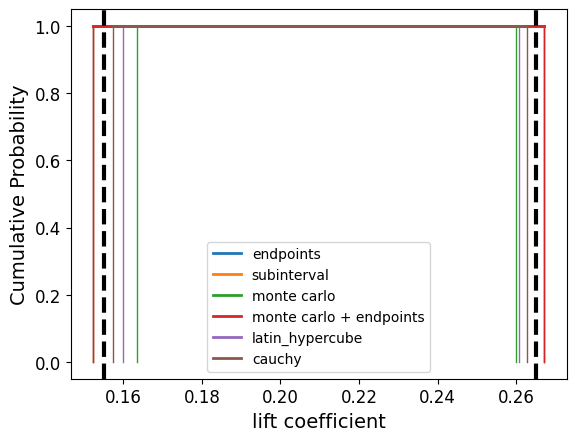

In [50]:
#plotting the lift coefficient
vars = [y_end.un[0], y_sub.un[0], y_mc.un[0], y_mc_end.un[0],y_lhs.un[0], y_cauchy.un[0]]
labels = ['endpoints', 'subinterval', 'monte carlo', 'monte carlo + endpoints','latin_hypercube',  'cauchy']

_= plot_interval(vars, colors=None, xlabel= "lift coefficient" , labels= labels, vlines =[0.155, 0.265])


C:\Users\Ioanna\AppData\Local\Temp\ipykernel_37036\3143960624.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10')  # Use 'tab10' colormap


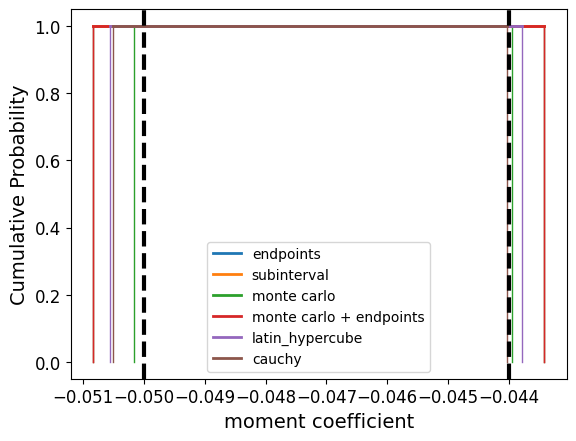

In [51]:
#plotting the moment coefficient
vars = [y_end.un[1], y_sub.un[1], y_mc.un[1], y_mc_end.un[1],y_lhs.un[1],y_cauchy.un[1]]
labels = ['endpoints', 'subinterval', 'monte carlo', 'monte carlo + endpoints','latin_hypercube',  'cauchy']

_= plot_interval(vars, colors=None, xlabel= "moment coefficient" , labels= labels, vlines =[-0.050,-0.044])


***
<a id="propagate_epistemic_uncertainty"></a>
# Mixed uncertainty